In [1]:
%matplotlib inline
import pandas as pd
from matplotlib import pyplot as plt
import os

In [24]:
def plott(dfs, columns, sufixes, x='Number of env steps total'):
    if len(columns) > 2:
        fig, axs = plt.subplots(2,2)
        figsize = (15, 10)
    else:
        fig, axs = plt.subplots(1,2)
        figsize = (15, 5)

    for j, df in enumerate(dfs):
        if df is not None:
            for i, column in enumerate(columns):
                if len(columns) > 2:
                    axspos = axs[int(i/2), int(i%2)]
                else:
                    axspos = axs[i]
                df.plot.line(x=x, y=column, ax=axspos, figsize=figsize, title=column)
                axspos.legend([column + ' ' + sufix for sufix in sufixes if sufixes])

In [3]:
progresses = []
for dirname, _, filenames in os.walk('output'):
    for filename in filenames:
        if 'progress' in filename:
            progresses.append(os.path.join(dirname, filename))
            print(os.path.join(dirname, filename))

output/walker-rand-params/2020_02_07_23_05_18/progress.csv
output/sparse-point-robot/2020_02_07_01_13_52/progress.csv
output/sparse-point-robot/2020_02_06_00_14_15/progress.csv
output/humanoid-dir/2020_02_04_21_55_51/progress.csv
output/humanoid-dir/2020_02_04_12_53_44/progress.csv
output/humanoid-dir/2020_02_05_20_18_45/progress.csv
output/humanoid-dir/2020_02_05_00_34_04/progress.csv
output/humanoid-dir/2020_02_05_00_35_33/progress.csv
output/humanoid-dir/2020_02_05_12_42_44/progress.csv
output/humanoid-dir/2020_02_05_12_42_18/progress.csv
output/humanoid-dir/2020_02_05_12_40_42/progress.csv
output/dgx-humanoid-dir/2020_02_04_12_53_44/progress.csv


In [35]:
labels = ['PEARL', 'PEARL']
results1 = pd.read_csv(progresses[1], skiprows=[1])
results2 = pd.read_csv(progresses[2], skiprows=[1])

if 'Mean Intrinsic Reward' in results1.columns:
    labels[0] = 'Intrinsic'

print('Results 1 steps:', results1['Number of env steps total'])
if results2 is not None:
    print('Results 2 steps:', results2['Number of env steps total'])
    if 'Mean Intrinsic Reward' in results2.columns:
        labels[0] = 'Intrinsic'

Results 1 steps: 0        36000
1        46000
2        56000
3        66000
4        76000
        ...   
304    3076000
305    3086000
306    3096000
307    3106000
308    3116000
Name: Number of env steps total, Length: 309, dtype: int64
Results 2 steps: 0        36000
1        46000
2        56000
3        66000
4        76000
        ...   
296    2996000
297    3006000
298    3016000
299    3026000
300    3036000
Name: Number of env steps total, Length: 301, dtype: int64


In [36]:
results2.columns

Index(['Z mean train', 'Z variance train', 'KL Divergence', 'KL Loss',
       'QF Loss', 'VF Loss', 'Policy Loss', 'Q Predictions Mean',
       'Q Predictions Std', 'Q Predictions Max', 'Q Predictions Min',
       'V Predictions Mean', 'V Predictions Std', 'V Predictions Max',
       'V Predictions Min', 'Log Pis Mean', 'Log Pis Std', 'Log Pis Max',
       'Log Pis Min', 'Policy mu Mean', 'Policy mu Std', 'Policy mu Max',
       'Policy mu Min', 'Policy log std Mean', 'Policy log std Std',
       'Policy log std Max', 'Policy log std Min', 'Decoder Loss',
       'Mean Intrinsic Reward', 'Z mean eval', 'Z variance eval',
       'AverageTrainReturn_all_train_tasks', 'AverageReturn_all_train_tasks',
       'AverageReturn_all_test_tasks', 'Number of train steps total',
       'Number of env steps total', 'Number of rollouts total',
       'Train Time (s)', '(Previous) Eval Time (s)', 'Sample Time (s)',
       'Epoch Time (s)', 'Total Train Time (s)', 'Epoch'],
      dtype='object')

In [37]:
print('Total steps', results1['Number of train steps total'][len(results1['Number of train steps total']) - 1])
print('Train time', results1['Total Train Time (s)'][len(results1['Total Train Time (s)']) - 1])

Total steps 310000
Train time 28986.659469533788


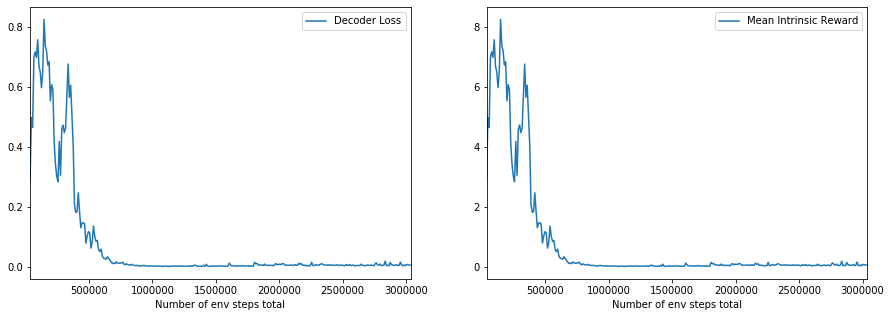

In [38]:
if ('Decoder Loss' in results1.columns and 'Mean Intrinsic Reward' in results1.columns) or \
    (results2 is not None and 'Decoder Loss' in results2.columns and 'Mean Intrinsic Reward' in results2.columns):
    fig, axs = plt.subplots(1, 2)
if 'Decoder Loss' in results1.columns and 'Mean Intrinsic Reward' in results1.columns:
    results1.plot.line(x='Number of env steps total', y='Decoder Loss', ax=axs[0], figsize=(15, 5))
    results1.plot.line(x='Number of env steps total', y='Mean Intrinsic Reward', ax=axs[1])
if results2 is not None and 'Decoder Loss' in results2.columns and 'Mean Intrinsic Reward' in results2.columns:
    results2.plot.line(x='Number of env steps total', y='Decoder Loss', ax=axs[0], figsize=(15, 5))
    results2.plot.line(x='Number of env steps total', y='Mean Intrinsic Reward', ax=axs[1])

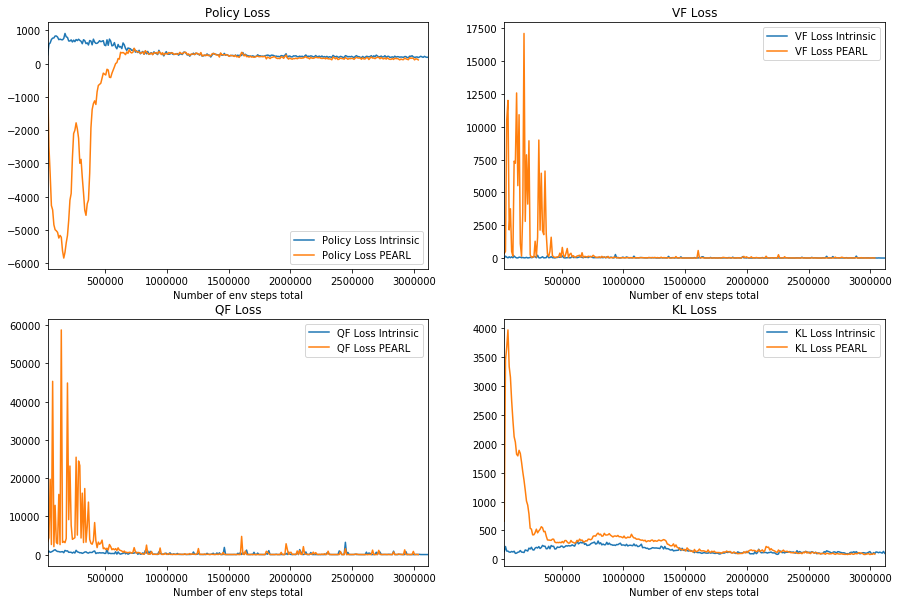

In [39]:
plott([results1, results2], ['Policy Loss', 'VF Loss', 'QF Loss', 'KL Loss'], labels)

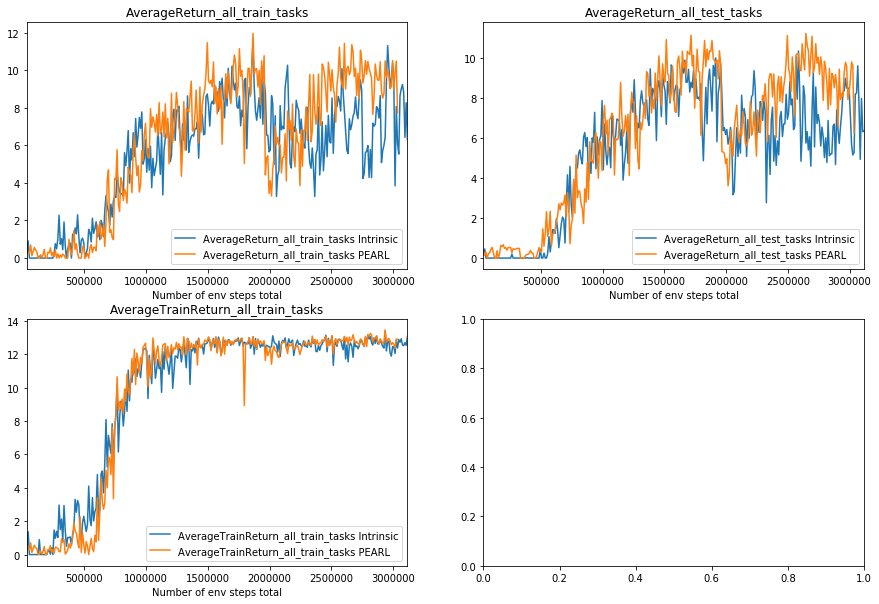

In [40]:
plott([results1, results2], ['AverageReturn_all_train_tasks', 'AverageReturn_all_test_tasks', 'AverageTrainReturn_all_train_tasks'], labels)

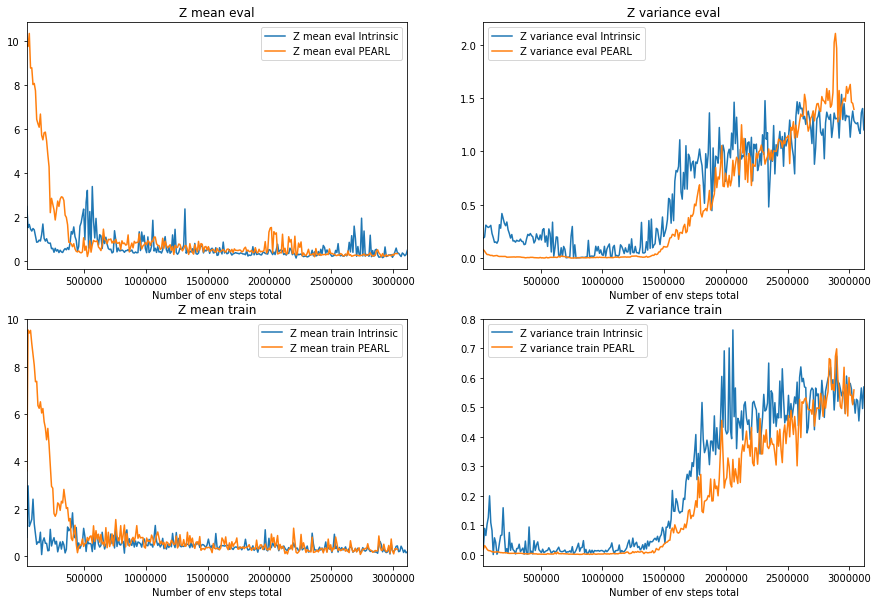

In [41]:
plott([results1, results2], ['Z mean eval', 'Z variance eval', 'Z mean train', 'Z variance train'], labels)

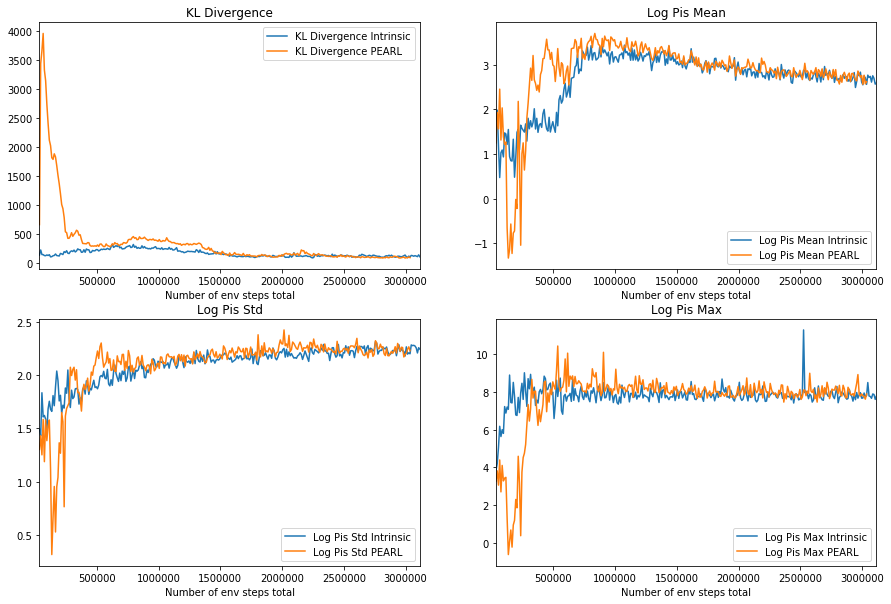

In [42]:
plott([results1, results2], ['KL Divergence', 'Log Pis Mean', 'Log Pis Std', 'Log Pis Max'], labels)

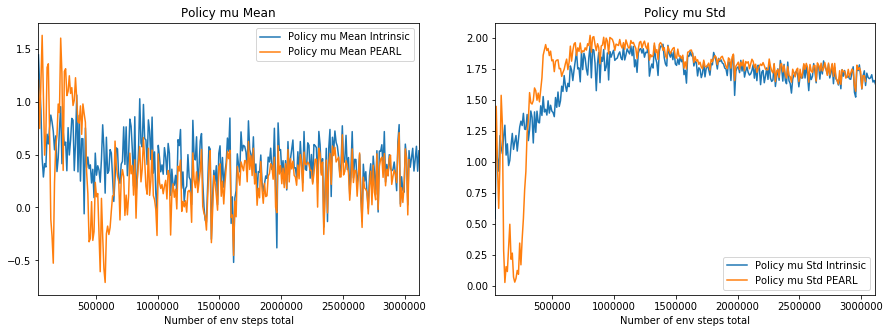

In [43]:
plott([results1, results2], ['Policy mu Mean', 'Policy mu Std'], labels)